# Simulation NREL 5MW wind turbine

In [1]:
%config InlineBackend.figure_format = 'svg'
from IPython.display import Image
url = 'https://raw.githubusercontent.com/ImperialCollegeLondon/sharpy/dev_doc/docs/source/content/example_notebooks/images/turbulence_no_legend.png'
Image(url=url, width=800)

In this notebook the blade loads on the NREL-5MW reference wind turbine computed with SHARPy and OpenFAST will be compared. However, zero-drag airfoils have been used.

OpenFAST: _https://openfast.readthedocs.io_

NREL-5MW: Jonkman, J.; Butterfield, S.; Musial, W. and Scott, G.. _Definition of a 5-MW Reference Wind Turbine for Offshore System Development_, Technical Report, NREL 2009

Load the required packages:

In [2]:
# Required packages
import numpy as np
import os
import matplotlib.pyplot as plt

# Required SHARPy modules
import sharpy.sharpy_main
import sharpy.utils.algebra as algebra
import sharpy.utils.generate_cases as gc
import cases.templates.template_wt as template_wt

These are the results from the OpenFAST simulation for comparison: out-of-plane `of_cNdrR` and in-plane `of_cTdrR` coefficients along the blade and thrust `of_ct` and power `of_cp` rotor coefficients

In [3]:
of_rR = np.array([0.20158356, 0.3127131, 0.40794048, 0.5984148, 0.6936519, 0.85238045, 0.899999, 0.95555407, 0.98729974, 1.0])
of_cNdrR = np.array([0.08621394, 0.14687876, 0.19345148, 0.2942731, 0.36003628, 0.43748564, 0.44762507, 0.38839236, 0.29782477, 0.0])
of_cTdrR = np.array([0.048268348, 0.051957503, 0.05304592, 0.052862607, 0.056001827, 0.0536646, 0.050112925, 0.038993906, 0.023664437, 0.0])

of_ct = 0.69787693
of_cp = 0.48813498

## Create SHARPy case

Definition of parameters

In [4]:
# Mathematical constants
deg2rad = np.pi/180.

# Case
case = 'rotor'
# route = os.path.dirname(os.path.realpath(__file__)) + '/'
route = './'

# Geometry discretization
chord_panels = np.array([8], dtype=int)
revs_in_wake = 5

# Operation
rotation_velocity = 12.1*2*np.pi/60
pitch_deg = 0. #degrees

# Wind
WSP = 12.
air_density = 1.225

# Simulation
dphi = 4.*deg2rad
revs_to_simulate = 5

Computation of associated parameters

In [5]:
dt = dphi/rotation_velocity
time_steps = int(revs_to_simulate*2.*np.pi/dphi)
mstar = int(revs_in_wake*2.*np.pi/dphi)

Generation of the rotor geometry based on the information in the excel file

In [6]:
rotor = template_wt.rotor_from_excel_type02(
                                  chord_panels,
                                  rotation_velocity,
                                  pitch_deg,
                                  excel_file_name= 'source/type02_db_NREL5MW_v01.xlsx',
                                  excel_sheet_parameters = 'parameters',
                                  excel_sheet_structural_blade = 'structural_blade',
                                  excel_sheet_discretization_blade = 'discretization_blade',
                                  excel_sheet_aero_blade = 'aero_blade',
                                  excel_sheet_airfoil_info = 'airfoil_info',
                                  excel_sheet_airfoil_coord = 'airfoil_coord',
                                  m_distribution = 'uniform',
                                  n_points_camber = 100,
                                  tol_remove_points = 1e-8,
                                  wsp = WSP,
                                  dt = dt)

rotor_from_excel_type02 is obsolete! rotor_from_excel_type03 instead!


Define simulation details. The steady simulation is faster than the dynamic simulation. However, the dynamic simulation includes wake self-induction and provides more accurate results.

In [7]:
steady_simulation = False

In [8]:
SimInfo = gc.SimulationInformation()
SimInfo.set_default_values()

if steady_simulation:
    SimInfo.solvers['SHARPy']['flow'] = ['BeamLoader',
                            'AerogridLoader',
                            'StaticCoupledRBM',
                            'BeamPlot',
                            'AerogridPlot',            
                            'SaveData'] 
else:
    SimInfo.solvers['SHARPy']['flow'] = ['BeamLoader',
                            'AerogridLoader',
                            'StaticCoupledRBM',
                            'DynamicCoupled']
                                         
SimInfo.solvers['SHARPy']['case'] = case
SimInfo.solvers['SHARPy']['route'] = route
SimInfo.solvers['SHARPy']['write_log'] = True
SimInfo.set_variable_all_dicts('dt', dt)
SimInfo.set_variable_all_dicts('rho', air_density)

SimInfo.solvers['SteadyVelocityField']['u_inf'] = WSP
SimInfo.solvers['SteadyVelocityField']['u_inf_direction'] = np.array([0., 0., 1.])

SimInfo.solvers['BeamLoader']['unsteady'] = 'on'

SimInfo.solvers['AerogridLoader']['unsteady'] = 'on'
SimInfo.solvers['AerogridLoader']['mstar'] = mstar
SimInfo.solvers['AerogridLoader']['freestream_dir'] = np.array([0.,0.,0.])
SimInfo.solvers['AerogridLoader']['wake_shape_generator'] = 'HelicoidalWake'
SimInfo.solvers['AerogridLoader']['wake_shape_generator_input'] = {'u_inf': WSP,
                                                                   'u_inf_direction': SimInfo.solvers['SteadyVelocityField']['u_inf_direction'],
                                                                   'rotation_velocity': rotation_velocity*np.array([0., 0., 1.]),
                                                                   'dt': dt,
                                                                   'dphi1': dphi,
                                                                   'ndphi1': mstar,
                                                                   'r': 1.,
                                                                   'dphimax': 10*deg2rad}
    
SimInfo.solvers['StaticCoupledRBM']['structural_solver'] = 'RigidDynamicPrescribedStep'
SimInfo.solvers['StaticCoupledRBM']['structural_solver_settings'] = SimInfo.solvers['RigidDynamicPrescribedStep']
SimInfo.solvers['StaticCoupledRBM']['aero_solver'] = 'StaticUvlm'
SimInfo.solvers['StaticCoupledRBM']['aero_solver_settings'] = SimInfo.solvers['StaticUvlm']

SimInfo.solvers['StaticCoupledRBM']['tolerance'] = 1e-8
SimInfo.solvers['StaticCoupledRBM']['n_load_steps'] = 0
SimInfo.solvers['StaticCoupledRBM']['relaxation_factor'] = 0.

SimInfo.solvers['StaticUvlm']['num_cores'] = 8
SimInfo.solvers['StaticUvlm']['velocity_field_generator'] = 'SteadyVelocityField'
SimInfo.solvers['StaticUvlm']['velocity_field_input'] = SimInfo.solvers['SteadyVelocityField']

SimInfo.solvers['SaveData']['compress_float'] = True
                                         
# Only used for steady_simulation = False
SimInfo.solvers['StepUvlm']['convection_scheme'] = 3
SimInfo.solvers['StepUvlm']['num_cores'] = 8
SimInfo.solvers['StepUvlm']['velocity_field_generator'] = 'SteadyVelocityField'
SimInfo.solvers['StepUvlm']['velocity_field_input'] = SimInfo.solvers['SteadyVelocityField']

SimInfo.solvers['DynamicCoupled']['structural_solver'] = 'RigidDynamicPrescribedStep'
SimInfo.solvers['DynamicCoupled']['structural_solver_settings'] = SimInfo.solvers['RigidDynamicPrescribedStep']
SimInfo.solvers['DynamicCoupled']['aero_solver'] = 'StepUvlm'
SimInfo.solvers['DynamicCoupled']['aero_solver_settings'] = SimInfo.solvers['StepUvlm']
SimInfo.solvers['DynamicCoupled']['postprocessors'] = ['BeamPlot', 'AerogridPlot', 'Cleanup', 'SaveData']
SimInfo.solvers['DynamicCoupled']['postprocessors_settings'] = {'BeamPlot': SimInfo.solvers['BeamPlot'],
                                                             'AerogridPlot': SimInfo.solvers['AerogridPlot'],
                                                             'Cleanup': SimInfo.solvers['Cleanup'],
                                                             'SaveData': SimInfo.solvers['SaveData']}
SimInfo.solvers['DynamicCoupled']['minimum_steps'] = 0
SimInfo.solvers['DynamicCoupled']['include_unsteady_force_contribution'] = True
SimInfo.solvers['DynamicCoupled']['relaxation_factor'] = 0.
SimInfo.solvers['DynamicCoupled']['final_relaxation_factor'] = 0.
SimInfo.solvers['DynamicCoupled']['dynamic_relaxation'] = False
SimInfo.solvers['DynamicCoupled']['relaxation_steps'] = 0

# Define dynamic simulation (used regardless the value of "steady_simulation" variable)
SimInfo.define_num_steps(time_steps)
SimInfo.with_forced_vel = True
SimInfo.for_vel = np.zeros((time_steps,6), dtype=float)
SimInfo.for_vel[:,5] = rotation_velocity
SimInfo.for_acc = np.zeros((time_steps,6), dtype=float)
SimInfo.with_dynamic_forces = True
SimInfo.dynamic_forces = np.zeros((time_steps,rotor.StructuralInformation.num_node,6), dtype=float)

Generate simulation files

In [9]:
gc.clean_test_files(SimInfo.solvers['SHARPy']['route'], SimInfo.solvers['SHARPy']['case'])
rotor.generate_h5_files(SimInfo.solvers['SHARPy']['route'], SimInfo.solvers['SHARPy']['case'])
SimInfo.generate_solver_file()
SimInfo.generate_dyn_file(time_steps)

## Run SHARPy case

In [10]:
sharpy_output = sharpy.sharpy_main.main(['', SimInfo.solvers['SHARPy']['route'] + SimInfo.solvers['SHARPy']['case'] + '.sharpy'])

--------------------------------------------------------------------------------
            ######  ##     ##    ###    ########  ########  ##    ##
           ##    ## ##     ##   ## ##   ##     ## ##     ##  ##  ##
           ##       ##     ##  ##   ##  ##     ## ##     ##   ####
            ######  ######### ##     ## ########  ########     ##
                 ## ##     ## ######### ##   ##   ##           ##
           ##    ## ##     ## ##     ## ##    ##  ##           ##
            ######  ##     ## ##     ## ##     ## ##           ##
--------------------------------------------------------------------------------
Aeroelastics Lab, Aeronautics Department.
    Copyright (c), Imperial College London.
    All rights reserved.
    License available at https://github.com/imperialcollegelondon/sharpy
Running SHARPy from /home/arturo/code/sharpy/docs/source/content/example_notebooks
SHARPy being run is in /home/arturo/code/sharpy
The branch being run is dev_minor_fixes_v1.2
The versio

|  31   | 1.7080 |  1   |   0.000377   |  36.473098   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  32   | 1.7631 |  1   |   0.000386   |  35.843986   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  33   | 1.8182 |  1   |   0.000387   |  35.850814   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  34   | 1.8733 |  1   |   0.000399   |  35.627213   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  35   | 1.9284 |  1   |   0.000386   |  35.592384   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  36   | 1.9835 |  1   |   0.000402   |  35.870112   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  37   | 2.0386 |  1   |   0.000383   |  36.312248   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  38   | 2.0937 |  1   |   0.000387   |  36.062439   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  39   | 2.1488 |  1   |   0.000388   |  35.772526   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  40   | 2.2039 |  1   |   0.000384   |  35.826909   |   0.000000   | 0.000000e+00 | 0.000

|  110  | 6.0606 |  1   |   0.000355   |  38.839836   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  111  | 6.1157 |  1   |   0.000355   |  38.759202   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  112  | 6.1708 |  1   |   0.000386   |  35.600075   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  113  | 6.2259 |  1   |   0.000385   |  35.839082   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  114  | 6.2810 |  1   |   0.000380   |  36.186849   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  115  | 6.3361 |  1   |   0.000377   |  36.621883   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  116  | 6.3912 |  1   |   0.000379   |  36.275201   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  117  | 6.4463 |  1   |   0.000378   |  35.842331   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  118  | 6.5014 |  1   |   0.000387   |  35.500655   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  119  | 6.5565 |  1   |   0.000385   |  36.050353   |   0.000000   | 0.000000e+00 | 0.000

|  189  |10.4132 |  1   |   0.000385   |  35.829776   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  190  |10.4683 |  1   |   0.000352   |  38.827525   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  191  |10.5234 |  1   |   0.000387   |  35.562966   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  192  |10.5785 |  1   |   0.000383   |  36.313870   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  193  |10.6336 |  1   |   0.000379   |  36.330277   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  194  |10.6887 |  1   |   0.000384   |  35.712089   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  195  |10.7438 |  1   |   0.000388   |  35.658495   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  196  |10.7989 |  1   |   0.000382   |  35.887891   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  197  |10.8540 |  1   |   0.000387   |  35.722417   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  198  |10.9091 |  1   |   0.000390   |  35.526182   |   0.000000   | 0.000000e+00 | 0.000

|  268  |14.7658 |  1   |   0.000384   |  35.878748   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  269  |14.8209 |  1   |   0.000384   |  35.956619   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  270  |14.8760 |  1   |   0.000388   |  35.757834   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  271  |14.9311 |  1   |   0.000386   |  35.516229   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  272  |14.9862 |  1   |   0.000382   |  35.664562   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  273  |15.0413 |  1   |   0.000388   |  35.536456   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  274  |15.0964 |  1   |   0.000380   |  35.959082   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  275  |15.1515 |  1   |   0.000384   |  35.817666   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  276  |15.2066 |  1   |   0.000388   |  35.632972   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  277  |15.2617 |  1   |   0.000381   |  36.023971   |   0.000000   | 0.000000e+00 | 0.000

|  347  |19.1185 |  1   |   0.000359   |  38.141883   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  348  |19.1736 |  1   |   0.000388   |  35.543387   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  349  |19.2287 |  1   |   0.000384   |  35.859722   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  350  |19.2837 |  1   |   0.000375   |  36.929390   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  351  |19.3388 |  1   |   0.000377   |  36.180960   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  352  |19.3939 |  1   |   0.000364   |  37.933742   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  353  |19.4490 |  1   |   0.000371   |  36.995525   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  354  |19.5041 |  1   |   0.000386   |  35.545846   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  355  |19.5592 |  1   |   0.000388   |  35.628378   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  356  |19.6143 |  1   |   0.000387   |  35.582392   |   0.000000   | 0.000000e+00 | 0.000

|  426  |23.4711 |  1   |   0.000392   |  35.489623   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  427  |23.5262 |  1   |   0.000389   |  35.608145   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  428  |23.5813 |  1   |   0.000384   |  35.740503   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  429  |23.6364 |  1   |   0.000389   |  35.533001   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  430  |23.6915 |  1   |   0.000384   |  35.683364   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  431  |23.7466 |  1   |   0.000390   |  35.601261   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  432  |23.8017 |  1   |   0.000391   |  35.618575   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  433  |23.8567 |  1   |   0.000378   |  36.598354   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  434  |23.9118 |  1   |   0.000378   |  36.427617   |   0.000000   | 0.000000e+00 | 0.000000e+00 |
|  435  |23.9669 |  1   |   0.000379   |  36.053304   |   0.000000   | 0.000000e+00 | 0.000

## Postprocessing

Read the structural and aerodynamic information of the last time step

In [11]:
tstep = sharpy_output.structure.timestep_info[-1]
astep = sharpy_output.aero.timestep_info[-1]

Separate the structure into blades

In [12]:
# Define beams
ielem = 0
nblades = np.max(sharpy_output.structure.beam_number) + 1
nodes_blade = []
first_node = 0
for iblade in range(nblades):
    nodes_blade.append(np.zeros((sharpy_output.structure.num_node,), dtype=bool))
    while sharpy_output.structure.beam_number[ielem] <= iblade:
        ielem += 1
        if ielem == sharpy_output.structure.num_elem:
            break
    nodes_blade[iblade][first_node:sharpy_output.structure.connectivities[ielem-1,1]+1] = True
    first_node = sharpy_output.structure.connectivities[ielem-1,1]+1

Compute the radial position of the nodes and initialise the rest of the variables

In [13]:
r = []
c = []
dr = []
forces = []
CN_drR = []
CTan_drR = []
CP_drR = []
nodes_num = []
for iblade in range(nblades):
    forces.append(tstep.steady_applied_forces[nodes_blade[iblade]].copy())

    nodes_num.append(np.arange(0, sharpy_output.structure.num_node, 1)[nodes_blade[iblade]])

    r.append(np.linalg.norm(tstep.pos[nodes_blade[iblade], :], axis=1))
    dr.append(np.zeros(np.sum(nodes_blade[iblade])))
    dr[iblade][0] = 0.5*(r[iblade][1]-r[iblade][0])
    dr[iblade][-1] = 0.5 * (r[iblade][-1] - r[iblade][-2])
    for inode in range(1,len(r[iblade]) - 1):
        dr[iblade][inode] = 0.5*(r[iblade][inode+1] - r[iblade][inode-1])

    CN_drR.append(np.zeros(len(r[iblade])))
    c.append(np.zeros(len(r[iblade])))
    CTan_drR.append(np.zeros(len(r[iblade])))
    CP_drR.append(np.zeros(len(r[iblade])))

Transform the loads computed by SHARPy into out-of-plane and in-plane components

In [14]:
rho = sharpy_output.settings['StaticCoupledRBM']['aero_solver_settings']['rho'].value
uinf = sharpy_output.settings['StaticCoupledRBM']['aero_solver_settings']['velocity_field_input']['u_inf'].value
R = np.max(r[0])
Cp = 0
Ct = 0

global_force_factor = 0.5 * rho * uinf** 2 * np.pi * R**2
global_power_factor = global_force_factor*uinf
for iblade in range(nblades):
    for inode in range(len(r[iblade])):
        forces[iblade][inode, 0] *= 0. # Discard the spanwise component

        node_global_index = nodes_num[iblade][inode]
        ielem = sharpy_output.structure.node_master_elem[node_global_index, 0]
        inode_in_elem = sharpy_output.structure.node_master_elem[node_global_index, 1]
        CAB = algebra.crv2rotation(tstep.psi[ielem, inode_in_elem, :])

        c[iblade][inode] = sharpy_output.aero.aero_dict['chord'][ielem,inode_in_elem]

        forces_AFoR = np.dot(CAB, forces[iblade][inode, 0:3])

        CN_drR[iblade][inode] = forces_AFoR[2]/dr[iblade][inode]*R / global_force_factor
        CTan_drR[iblade][inode] = np.linalg.norm(forces_AFoR[0:2])/dr[iblade][inode]*R  / global_force_factor
        CP_drR[iblade][inode] = np.linalg.norm(forces_AFoR[0:2])/dr[iblade][inode]*R  * r[iblade][inode]*rotation_velocity / global_power_factor

    Cp += np.sum(CP_drR[iblade]*dr[iblade]/R)
    Ct += np.sum(CN_drR[iblade]*dr[iblade]/R)

## Results

Plot of the loads along the blade

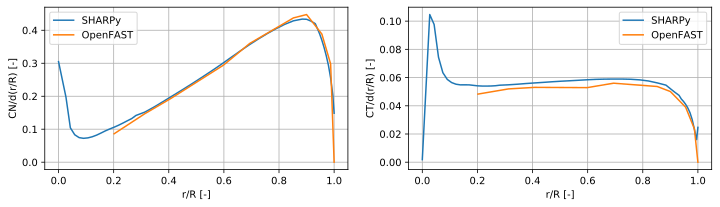

In [15]:
fig, list_plots = plt.subplots(1, 2, figsize=(12, 3))

list_plots[0].grid()
list_plots[0].set_xlabel("r/R [-]")
list_plots[0].set_ylabel("CN/d(r/R) [-]")
list_plots[0].plot(r[0]/R, CN_drR[0], '-', label='SHARPy')
list_plots[0].plot(of_rR, of_cNdrR, '-', label='OpenFAST')
list_plots[0].legend()

list_plots[1].grid()
list_plots[1].set_xlabel("r/R [-]")
list_plots[1].set_ylabel("CT/d(r/R) [-]")
list_plots[1].plot(r[0]/R, CTan_drR[0], '-', label='SHARPy')
list_plots[1].plot(of_rR, of_cTdrR, '-', label='OpenFAST')
list_plots[1].legend()

plt.show()

Print the rotor thrust and power coefficients

In [16]:
print("      OpenFAST SHARPy")
print("Cp[-] %.2f       %.2f" % (of_cp, Cp))
print("Ct[-] %.2f       %.2f" % (of_ct, Ct))

      OpenFAST SHARPy
Cp[-] 0.49       0.53
Ct[-] 0.70       0.74
